In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

In [4]:

def generate_data(sigma):
    a_mean = np.array([-1, -1])
    a_cov = sigma * np.array([2, 0.5, 0.5, 1]).reshape((2,2))
    a = np.random.multivariate_normal(mean=a_mean, cov=a_cov, size=100)
    b_mean = np.array([1, -1])
    b_cov = sigma * np.array([1, -0.5, -0.5, 2]).reshape((2,2))
    b = np.random.multivariate_normal(mean=b_mean, cov=b_cov, size=100)
    c_mean = np.array([0, 1])
    c_cov = sigma * np.array([1, 0, 0, 2]).reshape((2,2))
    c = np.random.multivariate_normal(mean=c_mean, cov=c_cov, size=100)
    return a, b, c

In [5]:
def initialize_params(sigma):
    mean_error_mean = np.zeros(2)
    mean_error_cov = np.array([1, 0, 0, 1]). reshape((2, 2))
    cov_error_mean = np.zeros(4)
    cov_error_cov = np.array([.1, 0, 0, 0, 0, .1, 0, 0, 0, 0, .1, 0, 0, 0, 0, .1]).reshape((4, 4))
    c1_mean = np.array([-1, -1]) + np.random.multivariate_normal(mean=mean_error_mean, cov=mean_error_cov)
    c1_cov = sigma * np.array([2, 0.5, 0.5, 1]).reshape((2,2)) #+ np.random.multivariate_normal(mean=cov_error_mean, cov=cov_error_cov).reshape((2,2))
    c2_mean = np.array([1, -1]) + np.random.multivariate_normal(mean=mean_error_mean, cov=mean_error_cov)
    c2_cov = sigma * np.array([1, -0.5, -0.5, 2]).reshape((2,2)) #+ np.random.multivariate_normal(mean=cov_error_mean, cov=cov_error_cov).reshape((2,2))
    c3_mean = np.array([0, 1]) + np.random.multivariate_normal(mean=mean_error_mean, cov=mean_error_cov)
    c3_cov = sigma * np.array([1, 0, 0, 2]).reshape((2,2)) #+ np.random.multivariate_normal(mean=cov_error_mean, cov=cov_error_cov).reshape((2,2))
    means = [c1_mean, c2_mean, c3_mean]
    covs = [c1_cov, c2_cov, c3_cov]
    return means, covs

In [7]:
def get_expectations(data, phi, mu, sig):
    n = len(data)
    p = len(phi)
    w = np.zeros(n * p).reshape((n, p))
    for i in range(n):
        d = 0
        for j in range(p):
            d += mvn.pdf(x=data[i], mean=mu[j], cov=sig[j]) * phi[j]
        for j in range(p):
            pz = phi[j]
            px = mvn.pdf(x=data[i], mean=mu[j], cov=sig[j])
            w[i, j] = (px * pz) / d
    return w

In [8]:
def maximize_params(data, weights):
    n = len(data)
    p = len(weights[0])
    phi = sum(weights) / n
    mu = (data.T.dot(weights) / sum(weights)).T
    d = phi * n
    # mu = []
    # for j in range(p):
    #     m = np.zeros(2)
    #     for i in range(n):
    #         m += weights[i, j] * data[i]
    #     mu.append(m / d[j])
    sig = []
    for j in range(p):
        s = np.zeros(4).reshape((2,2))
        for i in range(n):
            w = weights[i, j]
            v = data[i] - mu[j]
            s += w * np.outer(v, v)
        sig.append(s / d[j])
    return phi, mu, sig

In [9]:
def get_labels(weights):
    l = []
    for i in range(len(weights)):
        l.append(weights[i].argmax())
    return(l)


In [10]:



def get_loss(weights, labels):
    l = 0
    for i in range(len(labels)):
        l += np.log(weights[i][labels[i]])
    return -l 

def get_accuracy(source, labels):
    m = np.zeros(9).reshape(3, 3)
    n = len(labels)
    for it in range(n):
        i = labels[it]
        j = source[it]
        m[i, j] += 1
    a1 = (m[0, 0] + m[1, 1] + m[2, 2]) / n
    a2 = (m[0, 1] + m[1, 2] + m[2, 0]) / n
    a3 = (m[0, 2] + m[1, 0] + m[2, 1]) / n
    return max(a1, a2, a3)

def plot_gmm(data, labels, means):
    plt.scatter(data[:,0], data[:,1], c=labels, alpha=.5)
    plt.scatter(means[0][0], means[0][1], s=100, c="red", marker="*")
    plt.scatter(means[1][0], means[1][1], s=100, c="red", marker="*")
    plt.scatter(means[2][0], means[2][1], s=100, c="red", marker="*")
    plt.show()



In [11]:
def gmm(data, phi, mu, sig, epsilon):
    w0 = get_expectations(data, phi, mu, sig)
    l0 = get_labels(w0)
    loss0 = get_loss(w0, l0)
    p, m, s = maximize_params(data, w0)
    w1 = get_expectations(data, p, m, s)
    l1 = get_labels(w1)
    loss1 = get_loss(w1, l1)
    # if iter % 10 == 0:
    #     print(iter, get_loss(w1, l1))
    if abs(loss0 - loss1) < epsilon:
        return p, m, s, loss1
    else:
        return gmm(data, p, m, s, epsilon=epsilon)

# experiment
np.random.seed(5)
sigma = [0.5, 1, 2, 4, 8]
phi = np.array([1/3]*3).reshape(3)
loss = []
accuracy = []
source = np.array([[0] * 100, [1] * 100, [2] * 100]).reshape(300)
for i in range(len(sigma)):
    a, b, c = generate_data(sigma[i])
    data = np.array([a, b, c]).reshape(300, 2)
    mu, sig = initialize_params(sigma[i])
    p, m, s, l = gmm(data, phi, mu, sig, .1)
    loss.append(l)
    accuracy.append(get_accuracy(source, get_labels(get_expectations(data, p, m, s))))



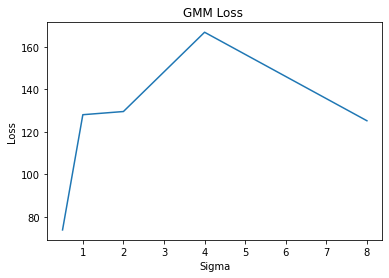

In [15]:
# plot
plt.plot(sigma, loss)
plt.ylabel("Loss")
plt.xlabel("Sigma")
plt.title("GMM Loss ")
plt.savefig("./gmm_loss.png")
plt.show()



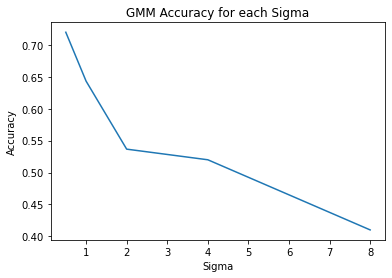

In [16]:
plt.plot(sigma, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Sigma")
plt.title("GMM Accuracy for each Sigma")
plt.savefig("./gmm_accuracy.png")
plt.show()
